In [43]:
import pandas as pd
import re
import matplotlib.pyplot as plt

def analyze_text_file(input_file_path, csv_output_path):

    # Define regex patterns to extract the required information
    test_output_pattern = re.compile(r'TEST OUTPUT = (\d+|None), RUNS_OK = (True|False), island_ID = (\w+)', re.MULTILINE)
    run_id_pattern = re.compile(r'\*{20,}(\d+): (\d+)', re.MULTILINE)

    # Initialize lists to store the extracted data
    data = []

    # Read the entire content of the file
    with open(input_file_path, 'r') as file:
        content = file.readlines()

    # Variables to track the current state
    current_data = {}
    run_counter = 0

    # Iterate over each line to extract the relevant information
    for line in content:
        test_output_match = test_output_pattern.search(line)
        if test_output_match:
            current_data['output_score'] = None if test_output_match.group(1) == 'None' else int(test_output_match.group(1))
            current_data['runs_ok'] = test_output_match.group(2) == 'True'
            current_data['island'] = test_output_match.group(3)
            current_data['run_id'] = run_counter
            run_counter += 1
            data.append(current_data.copy())
            current_data = {}
        else:
            run_id_match = run_id_pattern.search(line)
            if run_id_match and current_data:
                current_data['run_id'] = run_counter
                run_counter += 1
                data.append(current_data.copy())
                current_data = {}

    # Ensure the last collected data is also included
    if current_data:
        data.append(current_data.copy())

    # Create a DataFrame from the extracted data
    df = pd.DataFrame(data)

    # Save the DataFrame to a CSV file
    df.to_csv(csv_output_path, index=False)


    return

In [44]:
analyze_text_file('last_eval.txt', 'analysis/run_analysis.csv')

In [45]:
def generate_plot_from_csv(input_path: str, output_path: str, show=False):
    """
    Generates a plot of the cumulative maximum score over runs for each island from a CSV file and saves it to a specified path.
    
    Parameters:
    - input_path (str): Path to the input CSV file.
    - output_path (str): Path to save the output plot image.
    """
    # Load the CSV file
    data = pd.read_csv(input_path)
    
    # Filter the data to include only successful runs
    successful_runs = data[data['runs_ok'] == True]
    
    # Remove rows where 'island' is 'None' or NaN
    successful_runs = successful_runs[successful_runs['island'].notna()]
    
    # Convert 'island' column to integers
    successful_runs['island'] = successful_runs['island'].astype(int)
    
    # Calculate the cumulative maximum score for each island
    successful_runs['output_score'] = successful_runs['output_score'].fillna(0)
    successful_runs['cumulative_max'] = successful_runs.groupby('island')['output_score'].cummax()
    
    # Plot the cumulative maximum scores for each island
    plt.figure(figsize=(14, 8))
    
    for island, group in successful_runs.groupby('island'):
        plt.plot(group['run_id'], group['cumulative_max'], label=f'Island {island}')
    
    plt.xlabel('Run ID')
    plt.ylabel('Cumulative Maximum Score')
    plt.title('Cumulative Maximum Score Over Runs for Each Island')
    plt.legend()

    plt.grid(True)
    
    # Save the plot to the specified output path
    plt.savefig(output_path)
    if show:
        plt.show()
    plt.close()

    return

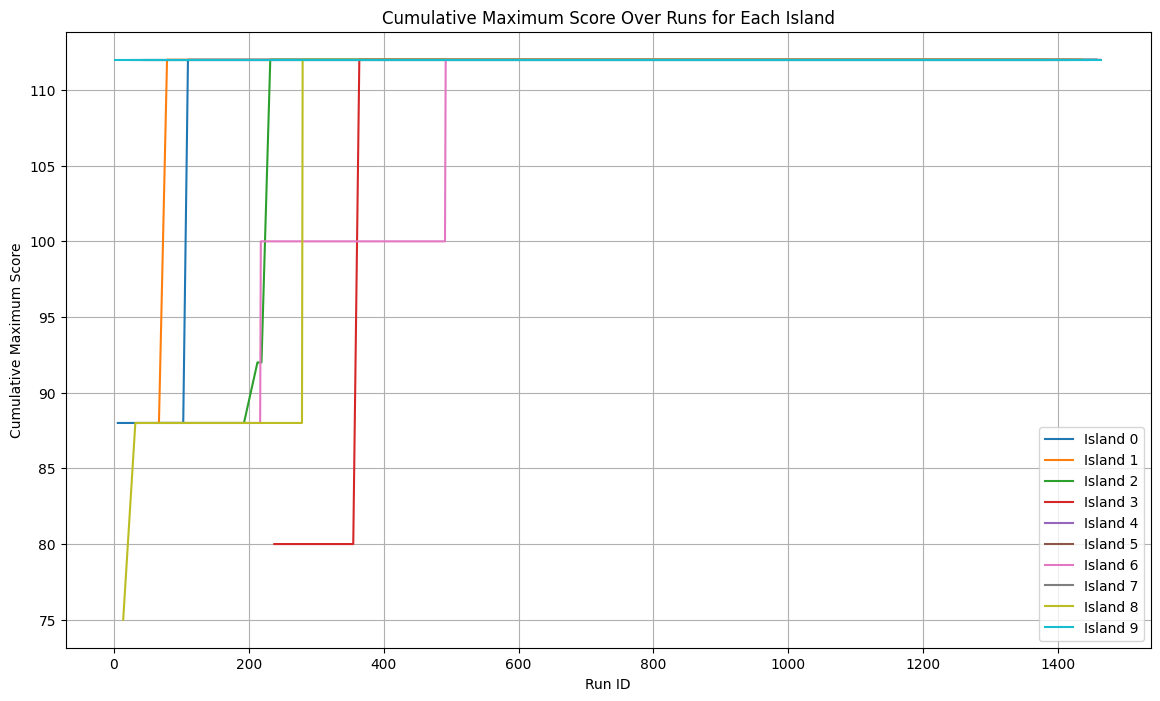

In [46]:
generate_plot_from_csv('analysis/run_analysis.csv', 'analysis/run_analysis_plot.png', show=True)



In [63]:
def count_outputs_and_plot(input_path: str, output_path: str, show=False):
    """
    Counts the number of false and correct outputs per island from a CSV file and plots the results in a bar graph.
    
    Parameters:
    - input_path (str): Path to the input CSV file.
    - output_path (str): Path to save the output bar graph image.
    """
    # Load the CSV file
    data = pd.read_csv(input_path)
    
    # Count the number of false and correct outputs per island
    island_counts = data.groupby(['island', 'runs_ok']).size().unstack(fill_value=0)
    #print(island_counts)
    print('succes rate = ' ,sum(island_counts[True])/ (sum(island_counts[False])+sum(island_counts[True])) *100,'%' )
    
    # Plot the counts in a bar graph
    island_counts.plot(kind='bar', stacked=True, figsize=(14, 8))
    
    plt.xlabel('Island')
    plt.ylabel('Count')
    plt.title('Number of False and Correct Outputs per Island')
    plt.legend(['False', 'True'])
    plt.grid(True)
    
    # Save the bar graph to the specified output path
    plt.savefig(output_path)

    if show:
        plt.show()
    plt.close()

runs_ok  False  True 
island               
0.0         96     50
1.0        110     48
2.0        109     57
3.0         97     55
4.0        100     60
5.0         89     41
6.0         93     49
7.0         91     39
8.0         83     35
9.0        100     62
succes rate =  33.87978142076503 %


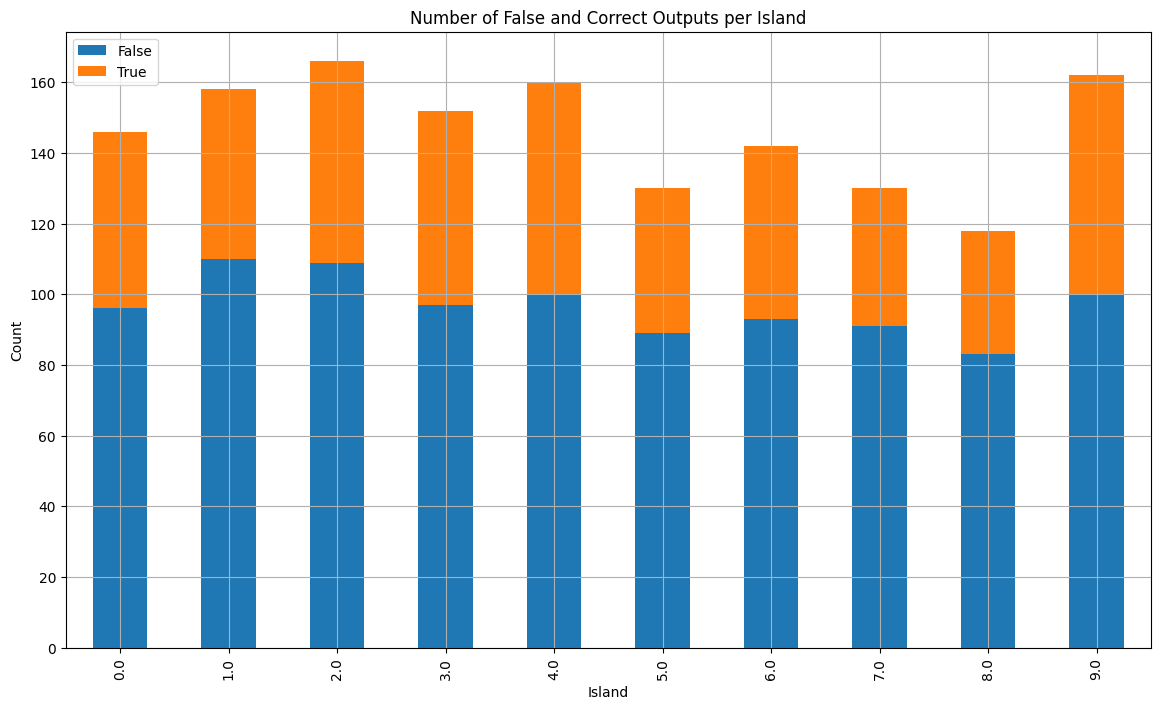

In [64]:
count_outputs_and_plot('analysis/run_analysis.csv', 'analysis/run_analysis_bargraph.png', True)